# [LOG2420 — Analyse et conception d’interfaces utilisateur]
# Introduction aux systemes de recommandations
Author: Kevin Gauthier et Jérémie David

## Chargement des données

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

votes = pd.read_csv("data/votes.csv", sep="|")
movies = pd.read_csv("data/items.csv", sep="|")
users = pd.read_csv("data/u.csv", sep="|")

movies_data = pd.merge(votes, movies, left_on="item.id", right_on="movie id ")
movies_data = pd.merge(movies_data, users, left_on="user.id", right_on="id ")

NB_USERS, NB_ITEMS = max(movies_data["user.id"].values), max(movies_data["item.id"].values)

movies_data.head()

,user.id,item.id,rating,timestamp,movie id,movie title,release date,video release date,IMDb URL,unknown,...,Romance,Sci-Fi,Thriller,War,Western,id,age,gender,job,zip
0,196,242,3,881250949,242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,...,0,0,0,0,0,196,49,M,writer,55105
1,196,257,2,881251577,257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,...,0,1,0,0,0,196,49,M,writer,55105
2,196,111,4,881251793,111,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,...,1,0,0,0,0,196,49,M,writer,55105
3,196,25,4,881251955,25,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,...,0,0,0,0,0,196,49,M,writer,55105
4,196,382,4,881251843,382,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,...,0,0,0,0,0,196,49,M,writer,55105


## Fonctions utiles

In [2]:
import numpy as np

def k_fold(data, folds=2, seed=None):
    """
    Train/Test split function using k folds
    :param data: The data to train/test split into k folds
    :param folds: Number of folds perform
    :param seed: Seed for randomization
    :return: Generator that can be iterated on to generate the train/test folds
    """
    indices = np.arange(len(data))
    np.random.seed(seed)
    np.random.shuffle(indices)

    index_folds = np.array_split(indices, folds)
    for i in range(folds):
        test_index = index_folds[i]
        train_index = np.concatenate(np.delete(index_folds, i, axis=0), axis=0)
        yield train_index, test_index

def rmse(y_pred, y_true):
    """
    Function that compute the RMSE between predictions and ground truth values
    :param y_pred: Array of predictions
    :param y_true: Ground truth values
    :return: The RMSE scalar value
    """
    return np.sqrt(np.average((y_true - y_pred) ** 2))


def cosine_similarity(X):
    """
    Function that compute the pairwise cosine similarity with X
    :param X: The matrix which the pairwise cosine similarity will be computed
    :return: Pairwise cosine similarity matrix of X
    """
    X_normalized = X / np.linalg.norm(X, axis=-1)[:, np.newaxis]
    return np.dot(X_normalized, X_normalized.T)


##  1. Création d'un baseline qui correspond à la moyenne de vote des items et des utilisateurs

In [3]:
class BaseLineModel:
    """
    Baseline model: Average together the means votes of users and items. Uses the mean of items and
    the means of users for unseen users/items.

    Implemented following sklearn's API design.
    """

    def __init__(self):
        """
        Model constructor
        """
        self.users_mean = None
        self.items_mean = None

    def fit(self, X):
        """
        Fit the model according to the given training data.
        :param pd.DataFrame X: Training samples
        """
        self.users_mean = X.groupby("user.id").agg({"rating": "mean"})
        self.users_mean.loc["UNKNOW"] = self.users_mean.mean()

        self.items_mean = X.groupby("item.id").agg({"rating": "mean"})
        self.items_mean.loc["UNKNOW"] = self.items_mean.mean()
   
    def predict(self, X):
        """
        Predict users-items rating for samples in X.
        :rtype: np.ndarray
        :param pd.DataFrame X: Test samples
        :return: Predicted rating per sample.
        """
        users_id = [i if i in self.users_mean.index else "UNKNOW" for i in X["user.id"].values]
        items_id = [i if i in self.items_mean.index else "UNKNOW" for i in X["item.id"].values]

        return (self.users_mean.loc[users_id].values.ravel() + self.items_mean.loc[items_id].values.ravel()) / 2

In [4]:
baseline = BaseLineModel()
folds_mse = []
for train_index, test_index in k_fold(movies_data, folds=10):
    train_fold, test_fold = movies_data.iloc[train_index], movies_data.iloc[test_index]

    baseline.fit(train_fold)
    fold_prediction = baseline.predict(test_fold)
    folds_mse.append(rmse(test_fold["rating"], fold_prediction))

print("RMSE of Baseline Model: {}".format(np.mean(folds_mse)))

RMSE of Baseline Model: 0.981702371189239


Text(0.5, 0, 'Fold')

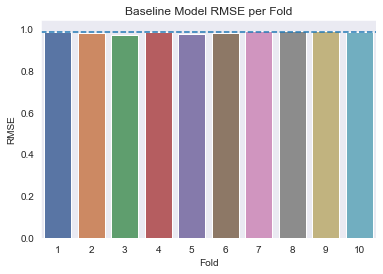

In [5]:
import seaborn as sns

sns.set_style("dark")

ax = sns.barplot(x=np.arange(1, len(folds_mse) + 1), y=folds_mse, palette="deep")
ax.axhline(np.mean(folds_mse), ls='--')

ax.set_title('Baseline Model RMSE per Fold')
ax.set_ylabel('RMSE')
ax.set_xlabel('Fold')

## 2. Approche Item-Item avec le cosinus comme mesure de similarité (avec seulement 10 voisins)

In [6]:
import scipy.sparse as sp

class ItemItemModel:
    """
    Item-Item model: model that follow equation 1 p.20/39 of "filtres collaboratifs"

    Implemented following sklearn's API design.
    """

    def __init__(self, k):
        """
        Model constructor
        :param k: Number of neighbours to perform the prediction
        """
        self.k = k
        self.sparse_x = None
        self.similarity = None
        self.results_matrix = None

    def fit(self, X):
        """
        Fit the model according to the given training data.
        :param pd.DataFrame X: Training samples
        """
        users, items, data = X["user.id"].values - 1, X["item.id"].values - 1, X["rating"].values

        # We transpose our votes matrix (Users-Items -> Items-Users) --> To directly apply the equation (1) in p.20
        self.votes_matrix = sp.csr_matrix((data, (items, users)), shape=(NB_ITEMS, NB_USERS)).toarray()
        self.similarity = cosine_similarity(self.votes_matrix)

        self.results_matrix = np.empty(self.votes_matrix.shape)
        neighbours = (-self.similarity).argsort(axis=1)[:, 1: self.k + 1] # Matrix that keeps the 10 neighbours for all items
        for item in range(self.similarity.shape[0]):
            V = self.votes_matrix[neighbours[item]]
            mask = (V > 0)

            means = V.sum(axis=1) / V.astype(bool).sum(axis=1)
            V_0 = V - means.reshape(-1, 1)
            np.place(V_0, ~mask, 0)

            w = self.similarity[item, neighbours[item]]
            k = 1 / np.abs(w[:, np.newaxis] * mask).sum(axis=0)
            k[k == np.inf] = 0

            row_predictions = k * (w @ V_0) + (self.votes_matrix[item].sum() / self.votes_matrix[item].astype(bool).sum())
            self.results_matrix[item] = np.clip(row_predictions, 1, 5)

    def nb_common_neigbhours(self):
        """
        Function that compute the number of common neigbhours per item
        :return: Number of common neighbours for each items (neighbours
                that have at least one common vote)
        """
        results = []
        neighbours = (-self.similarity).argsort(axis=1)[:, 0: self.k + 1]
        for item in range(self.similarity.shape[0]):
            V = self.similarity[neighbours[item]]
            mask = (V > 0).astype(int)
            C = mask @ mask.T
            results.append((C > 0).sum(axis=1)[0] - 1)

        return results

    def similarity_values(self):
        """
        Function that return all the similarities (w values) used to make the predictions
        :return: Array of similarities (w)
        """
        neighbours = (-self.similarity).argsort(axis=1)[:, 1: self.k + 1]
        w = np.empty(neighbours.shape)
        for item in range(neighbours.shape[0]):
            w[item] = self.similarity[item, neighbours[item]]

        return w.ravel()

    def nb_common_neigbhours_minus_missings(self, X):
        """
        Function that return the number of actual neighbours used for all the predicitons
        :param pd.DataFrame X: Values to predict
        :return: Number of neighbours used for each value to predict
        """
        result_matrix = np.empty(self.votes_matrix.shape)
        neighbours = (-self.similarity).argsort(axis=1)[:, 1: self.k + 1]
        for item in range(self.similarity.shape[0]):
            V = self.votes_matrix[neighbours[item]]
            mask = (V > 0)
            nb_non_missing_votes = mask.sum(axis=0)
            result_matrix[item] = nb_non_missing_votes

        return [result_matrix[item, user] for item, user in zip(X["item.id"].values - 1, X["user.id"].values - 1)]

    def predict(self, X):
        """
        Predict users-items rating for samples in X.
        :rtype: np.ndarray
        :param pd.DataFrame X: Test samples
        :return: Predicted rating per sample.
        """
        return [self.results_matrix[item, user] for item, user in zip(X["item.id"].values - 1, X["user.id"].values - 1)]

In [7]:
item_item_model = ItemItemModel(k=10)
item_item_model.fit(movies_data)

### Calcul pour l'item 1

In [8]:
item1_data = movies_data[movies_data["item.id"] == 1]
item1_predictions = item_item_model.predict(item1_data)

item1_rmse_value = rmse(item1_data["rating"].values, item1_predictions)

print("RMSE of item-item model (predictions for item 1 only): {}".format(item1_rmse_value))

RMSE of item-item model (predictions for item 1 only): 0.9176293181270241


### RMSE du model Item-Item

RMSE of item-item model: 0.9169955278866592


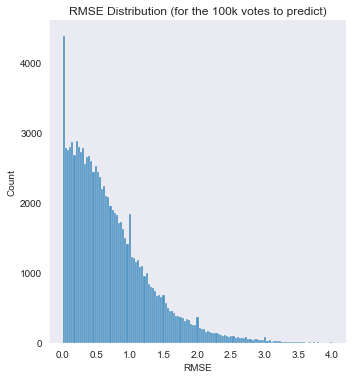

In [9]:
predictions = item_item_model.predict(movies_data)
rmse_distibution = [rmse(gt, pred) for gt, pred in zip(movies_data["rating"].values, predictions)]

rmse_distibution_plot = sns.displot(rmse_distibution)
rmse_distibution_plot.set(xlabel = "RMSE", title="RMSE Distribution (for the 100k votes to predict)")

rmse_value = rmse(movies_data["rating"].values, predictions)
print("RMSE of item-item model: {}".format(rmse_value))

## 2. Approche par facteur latent avec SVD

In [10]:
class SVDModel:
    """
    SVD model: model that perform dimensionality reduction using SVD (aka LSA).

    Implemented following sklearn's API design.
    """

    def __init__(self, n_components):
        """
        Model constructor
        :param n_components: Number of latent dimension to keep
        """
        self.n_components = n_components
        self.predictions_matrix = None

    def fit(self, X):
        """
        Fit the model according to the given training data.
        :param pd.DataFrame X: Training samples
        """
        users, items, data = X["user.id"].values - 1, X["item.id"].values - 1, X["rating"].values
        votes_matrix = sp.csr_matrix((data, (users, items)), dtype=float, shape=(NB_USERS, NB_ITEMS)).toarray()

        # Filling missing values (mean of users + mean of items / 2)
        mask = votes_matrix > 0
        row_means = votes_matrix.sum(axis=1) / votes_matrix.astype(bool).sum(axis=1)
        col_means = np.nan_to_num((votes_matrix.sum(axis=0) / votes_matrix.astype(bool).sum(axis=0)), nan=2.5)
        fill_values = (row_means.reshape(-1, 1) + col_means.reshape(1, -1)) / 2
        votes_matrix = np.where(mask, votes_matrix, fill_values)

        U, s, V = np.linalg.svd(votes_matrix, full_matrices=False)
        self.predictions_matrix = U[:, :self.n_components] @ np.diag(s[:self.n_components]) @ V[:self.n_components]

    def predict(self, X):
        """
        Predict users-items rating for samples in X.
        :rtype: np.ndarray
        :param pd.DataFrame X: Test samples
        :return: Predicted rating per sample.
        """
        results = []
        for user, item in zip(X["user.id"].values - 1, X["item.id"].values - 1):
            prediction = self.predictions_matrix[user, item]
            results.append(np.clip(prediction, 1, 5))

        return results

In [ ]:
latent_dimensions = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]
svd_rmse = []
for i in latent_dimensions:
    svd_model = SVDModel(n_components=i)
    folds_rmse = []
    for train_index, test_index in k_fold(movies_data, folds=5):
        train_fold, test_fold = movies_data.iloc[train_index], movies_data.iloc[test_index]

        svd_model.fit(train_fold)
        fold_prediction = svd_model.predict(test_fold)
        folds_rmse.append(rmse(test_fold["rating"].values, fold_prediction))

    svd_rmse.append(np.mean(folds_rmse))
    print("RMSE of SVD model ({} latent dimensions): {}".format(i, np.mean(folds_rmse)))

RMSE of SVD model (1 latent dimensions): 0.9726696709040071
RMSE of SVD model (2 latent dimensions): 0.9636233186302112
RMSE of SVD model (3 latent dimensions): 0.9548556749502042
RMSE of SVD model (4 latent dimensions): 0.9544374342534059


In [ ]:
svd_models_rmse_plot = sns.scatterplot(x=latent_dimensions, y=svd_rmse, palette="deep")

svd_models_rmse_plot.set_title('SVD Model RMSE per number of components')
svd_models_rmse_plot.set_ylabel('RMSE')
svd_models_rmse_plot.set_xlabel('Number of Components')

# Let's keep the latent dimension which had the lowest RMSE
best_svd_model_index = np.argmin(svd_rmse)
optimal_latent_dimensions = latent_dimensions[best_svd_model_index]
print("Best SVD model:\n    Number Latent Dimensions: {}\n    RMSE: {}".format(optimal_latent_dimensions, svd_rmse[best_svd_model_index]))

## 3. Approche basée contenu

### Chargenent des données

In [ ]:
citeseer_data = pd.read_csv("data/citeseer.rtable", delimiter=" ")
citation_matrix = citeseer_data.to_numpy()

# Fill the diagonal with 1 (self citation) so that we don't have division by 0 in the page rank algo
np.fill_diagonal(citation_matrix, 1)

citeseer_data.head()

In [ ]:
# Data loading
abstract_data = pd.read_csv("data/abstracts2.csv")
abstract_data = abstract_data.set_index("Id")
abstract_data = abstract_data.reindex(citeseer_data.index)

# Fill with empty string the documents that have null title, authors and description
abstract_data.fillna("", inplace=True)
abstract_data.head()

### Prétraitement des données: raw abstract descriptions --> tokenized descriptions --> lemmatized descriptions --> stemmed descriptions --> TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import RegexpTokenizer, SnowballStemmer, WordNetLemmatizer, pos_tag
from nltk.corpus import wordnet as wn, stopwords
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


class VectorSpaceModel:
    """
    Vector Space Model: model that computes the cosine similarity between a list of vectors (rows of any matrix)

    Implemented following sklearn's API design.
    """

    def __init__(self, nb_predictions=10):
        """
        Model constructor
        :param nb_predictions: Number of predictions to compute
        """
        self.nb_predictions = nb_predictions
        self.neighbours = None

    def fit_predict(self, X):
        """
        Compute the cosine similarity for every vector (rows) in X and returns the N most similar
        :param np.array X: input matrix to perform the similarity
        :return: matrix containing the N most similar vectors for each vector in X (sorted by descending similarity)
        """
        cosine_similarity_matrix = cosine_similarity(X)
        self.neighbours = (-cosine_similarity_matrix).argsort(axis=1)[:, 1: self.nb_predictions + 1]

        return self.neighbours
    

class DocTermMatrixModel:
    """
    Document-term Matrix Model (TFIDF): Class that transform a list of documents into a TFIDF matrix
    to perform predictions.

    Implemented following sklearn's API design.
    """
    def __init__(self, ngram_range=(1, 1)):
        """
        Model constructor
        :param ngram_range: The lower and upper boundary of the range of n-values
        for different n-grams to be extracted. (Used for question 5)
        """
        self.tfidf_vectorizer = TfidfVectorizer(tokenizer=self._tokenizer, ngram_range=ngram_range)
        self.stopwords = set(stopwords.words('english'))
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.stemmer = SnowballStemmer("english")
        self.lemmer = WordNetLemmatizer()

    @staticmethod
    def _get_wordnet_pos(tag):
        """
        Function that returns the wordnet pos tag to pass to the WordNetLemmatizer
        :param tag: the tag returned by the pos_tag function
        :return: the tag expected by WordNetLemmatizer
        """
        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('V'):
            return wn.VERB
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        else:
            return wn.NOUN

    def _tokenizer(self, text):
        """
        Function that preprocesses (tokenize, stem and lemmatize) a text
        :param text: the text to preprocess
        :return: the text preprocessed into a list of token
        """
        tokens = self.tokenizer.tokenize(text)
        processed_tokens = []
        for token, tag in pos_tag(tokens):
            if token.lower() not in self.stopwords and len(token) > 1 and token.isalpha():
                lem_token = self.lemmer.lemmatize(token, self._get_wordnet_pos(tag))
                stem_token = self.stemmer.stem(lem_token)
                processed_tokens.append(stem_token)

        return processed_tokens

    def fit_transform(self, X):
        """
        Fit the model according to the given training data and return the document-term matrix.
        Learn the vocabulary and the idf
        :param X: the documents
        :return: the document-term matrix
        """
        return self.tfidf_vectorizer.fit_transform(X)

In [ ]:
term_doc_matrix_model = DocTermMatrixModel()
TFIDF_matrix = term_doc_matrix_model.fit_transform(abstract_data["Description"])

### Exemple de recommandation pour un document

In [ ]:
tfidf_model = VectorSpaceModel(nb_predictions=10)
recommendation_indices = tfidf_model.fit_predict(TFIDF_matrix.toarray())

print("Documents to recommend (for doc 422908):")
doc_id = abstract_data.index.get_loc(422908)
abstract_data.iloc[recommendation_indices[doc_id]]

In [ ]:
print("Document 422908:")
abstract_data.loc[422908]

 ## 4. Apprentissage non-supervisé (Clustering) K-means

In [ ]:
from sklearn.cluster import KMeans

class KMeansModel:
    """
    K-Means model: model that perform K-Means clustering and average the votes of all the users
    that are in the same clusters per item.

    Implemented following sklearn's API design.
    """

    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.k_means = KMeans(n_clusters=n_clusters)
        self.clusters_means = None

    def fit(self, X):
        """
        Fit the model according to the given training data.
        :param pd.DataFrame X: Training samples
        """
        users, items, data = X["user.id"].values - 1, X["item.id"].values - 1, X["rating"].values
        votes_matrix = sp.csr_matrix((data, (users, items)), shape=(NB_USERS, NB_ITEMS)).toarray()

        # Filling missing values (mean of users + mean of items / 2)
        mask = votes_matrix > 0
        row_means = votes_matrix.sum(axis=1) / votes_matrix.astype(bool).sum(axis=1)
        col_means = np.nan_to_num((votes_matrix.sum(axis=0) / votes_matrix.astype(bool).sum(axis=0)), nan=2.5)
        fill_values = (row_means.reshape(-1, 1) + col_means.reshape(1, -1)) / 2
        votes_matrix = np.where(mask, votes_matrix, fill_values)

        corr_matrix = np.corrcoef(votes_matrix)
        self.k_means.fit(corr_matrix)

        self.clusters_means = np.empty((self.n_clusters, NB_ITEMS))
        for cluster in range(self.n_clusters):
            users_index = np.argwhere(self.k_means.labels_ == cluster).ravel()
            self.clusters_means[cluster] = votes_matrix[users_index].sum(axis=0) / votes_matrix[users_index].astype(bool).sum(axis=0)

        row_means = np.nanmean(self.clusters_means, axis=1)
        self.clusters_means = np.where(np.isnan(self.clusters_means), row_means.reshape(-1, 1), self.clusters_means)

    def predict(self, X):
        """
        Predict users-items rating for samples in X.
        :rtype: np.ndarray
        :param pd.DataFrame X: Test samples
        :return: Predicted rating per sample.
        """
        predictions = []
        for user, item in zip(X["user.id"].values - 1, X["item.id"].values - 1):
            cluster = self.k_means.labels_[user]
            predictions.append(self.clusters_means[cluster, item])

        return predictions

In [ ]:
nb_of_classes = [5, 10, 20, 40, 80]
kmeans_rmse = []
for i in nb_of_classes:
    kmeans_model = KMeansModel(n_clusters=i)
    folds_rmse = []
    for train_index, test_index in k_fold(movies_data, folds=5):
        train_fold, test_fold = movies_data.iloc[train_index], movies_data.iloc[test_index]

        kmeans_model.fit(train_fold)
        fold_prediction = kmeans_model.predict(test_fold)
        folds_rmse.append(rmse(test_fold["rating"].values, fold_prediction))

    kmeans_rmse.append(np.mean(folds_rmse))
    print("RMSE of K-Means Model ({} Classes): {}".format(i, np.mean(folds_rmse)))

In [ ]:
kmeans_models_rmse_plot = sns.scatterplot(x=nb_of_classes, y=kmeans_rmse, palette="deep")

kmeans_models_rmse_plot.set_title('K-Means Model RMSE per number of clusters')
kmeans_models_rmse_plot.set_ylabel('RMSE')
kmeans_models_rmse_plot.set_xlabel('Number of Clusters')

best_kmean_model_index = np.argmin(kmeans_rmse)
optimal_class = nb_of_classes[best_kmean_model_index]
print("Best K-Means Model:\n    Number of Class: {}\n    RMSE: {}".format(optimal_class, kmeans_rmse[best_kmean_model_index]))